# Reinforcement learning - 4 op een rij

Reinforcement learning komt uit de studie van Markov Chains of Processen voor.
Dit is een random opeenvolging van states waarbij elke transisitie een mogelijke kans heeft.
Door een reward te koppelen aan elke state waarin je komt kan je een functie opstellen die de de totale reward maximaliseert.
Dit is het basisidee achter reinforcement learning.

Een aantal belangrijke termen/concepten hierbij zijn:
* De agent
* Het environment
* De state space
* De action space
* De reward en return
* Exploration vs exploitation

## Q-learning

Een eerste algoritme dat we bekijken voor reinforcement learning uit te voeren is Q-learning.
Dit algoritme maakt gebruik van de Q-functie of action-value function.
Hiervoor houdt het Q-learning algoritme een matrix bij dat de reward van actie in een state bepaald.
In een verkenningsfase laten we toe dat er sub-optimale keuzes genomen worden.
Nadat dit lang genoeg gerund heeft, gaan we over naar een exploitation fase waarbij enkel de beste keuzes genomen worden.

Om te tonen hoe je het Q-learning algoritme kan implementeren, kan je gebruik maken van het [gymnasium package](https://gymnasium.farama.org/).
Dit bevat heel wat eenvoudige environments van spelletjes in python die hiervoor gebruikt kunnen worden.

In onderstaande code gaan we een AI-model maken om vier op een rij te spelen.
Het environment (met reeds een aantal ingebouwde AI-agents) kan je [hier](https://github.com/lucasBertola/Connect-4-Gym-env-Reinforcement-learning/tree/main) vinden.
In onderstaande code-cell toon ik een demo van hoe je zelf tegen een Agent 4 op een rij kan spelen.

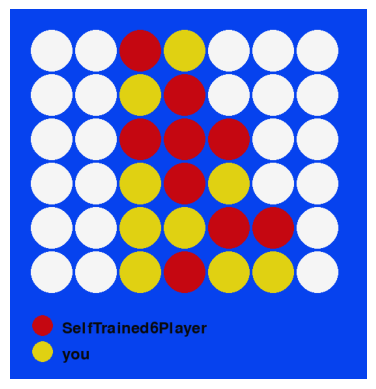

Enter a move between 1 and 7:  6


[[ 0  0 -1  1  0  0  0]
 [ 0  0  1 -1  0  0  0]
 [ 0  0 -1 -1 -1 -1  0]
 [ 0  0  1 -1  1  1  0]
 [ 0  0  1  1 -1 -1  0]
 [ 0  0  1 -1  1  1  0]]
-1
player lost


In [1]:
from connect_four_gymnasium import ConnectFourEnv
from connect_four_gymnasium.players import SelfTrained6Player
from connect_four_gymnasium.players import ConsolePlayer
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

you = ConsolePlayer()
env = ConnectFourEnv(opponent= SelfTrained6Player(deterministic=True), render_mode="rgb_array",main_player_name="you")

obs , _=  env.reset()
for i in range(5000):

    # dit is om het spelbord te tonen
    clear_output(wait=True)
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    display(plt.gcf())
    plt.close()  # close the figure to avoid memory buildup
    
    action = you.play(obs)
    obs, rewards, done, truncated,info = env.step(action)

    print(obs)
    print(rewards)
    
    if(truncated or done):
        if rewards > 0:
            print("player won")
            break
        else:
            print("player lost")
            break
        obs , _=  env.reset()

Zoals reeds eerder besproken hebben we bij reinforcement learning hebben we de volgende zaken nodig om een AI model te trainen:
* De mogelijke acties die het AI-model kan nemen (action space)
* De state van de environment dat gedetecteerd wordt door het model (observation space)
* De beloningen uitgestuurd door het systeem

Wat deze zaken voorstellen en welke structuur deze waarden hebben hangt sterk af van de specifieke omgeving en kan dus vaak opgezocht worden in de documentatie van de omgeving.
Door het uitprinten van de observatie en de reward hebben we reeds een indicatie van wat de omgeving/environment bijhoudt als interne state en uitstuurt als beloning.

In dit geval hebben we de volgende kenmerken:
* action space: een getal tussen 1 en 7 (welke kolom je een stuk inplaatst)
* observation space: een matrix van 6x7 met 0 als de plaats vrij is, 1 en -1 als respectievelijk speler 1 of speler 2 er een munt geplaatst heeft
* rewards: 0 als het spel bezig is, 1 als speler 1 gewonnen heeft (of speler 2 een ongeldige zet gedaan heeft) en -1 als speler 2 gewonnen heeft (of speler 1 een ongeldige zet gedaan heeft).

## Oefening - Random agent

Schrijf een AI-agent die random zetten neemt. Hiervoor schrijf je een klasse RandomAgent die een subklasse is van de base-klasse Player in de library.
De base klasse heeft de volgende structuur:
```python
class Player:
    def __init__(self, name):
        self.name = name

    def play(self, observation):
        raise NotImplementedError("The 'play' method must be implemented in the child class")

    def getElo(self):
        return None
    
    def getName(self):
        return self.name

    def isDeterministic(self):
        raise NotImplementedError("The 'isDeterministic' method must be implemented in the child class")
```

Zorg er daarna voor dat je een spel kan spelen tegen je eigen geschreven agent.

In [2]:
from connect_four_gymnasium.players import Player
import random

class RandomPlayer(Player.Player):

    def __init__(self, name, seed=None):
        super().__init__(name)

        self.isDeterministic = seed is not None
        self.seed = seed
        self.rng = random.Random(seed)

    def play(self, observation):
        return self.rng.randint(0,6)

    def isDeterministic(self):
        return self.isDeterministic

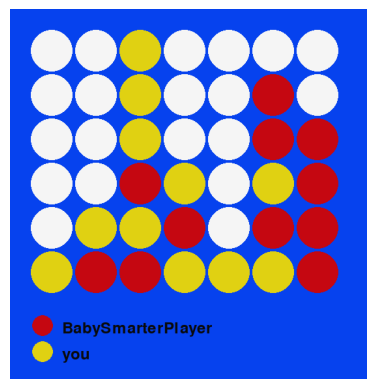

[[ 0  0  1  0  0  0  0]
 [ 0  0  1  0  0 -1  0]
 [ 0  0  1  0  0 -1 -1]
 [ 0  0 -1  1  0  1 -1]
 [ 0  1  1 -1  0 -1 -1]
 [ 1 -1 -1  1  1  1 -1]]
-1
player lost


In [8]:
from connect_four_gymnasium.players import BabySmarterPlayer

# maak het spel
you = RandomPlayer('you')
env = ConnectFourEnv(opponent= BabySmarterPlayer('easiest'), render_mode="rgb_array",main_player_name="you")

# reset het spel
obs, _ = env.reset()

# gamelus
for i in range(5000):
    # bereken een nieuwe actie
    action = you.play(obs)
    print(action)
    # voer de actie uit
    obs, rewards, done, truncated,info = env.step(action)

    # leren doet de random agent niet
    
    # dit is om het spelbord te tonen
    clear_output(wait=True)
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    display(plt.gcf())
    plt.close()  # close the figure to avoid memory buildup

    print(obs)
    print(rewards)
    
    if(truncated or done):
        if rewards > 0:
            print("player won")
            break
        else:
            print("player lost")
            break
        obs , _=  env.reset()

Op dit moment kunnen we deze agent een aantal keer 4 op een rij laten spelen tegen een andere speler.
Doe dit hieronder en bekijk het winstpercentage tegen verschillende opponenten.
Ga in de documentatie op zoek naar een aantal tegenstanders

In [21]:
from tqdm import tqdm
from connect_four_gymnasium.players import BabySmarterPlayer

you = RandomPlayer("random")
env = ConnectFourEnv(opponent= BabySmarterPlayer("easiest"), main_player_name="you")

n_episodes = 1000
wins = 0
losses = 0

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = you.play(obs)
        obs, rewards, done, truncated,info = env.step(action)

        if truncated or done:
            if rewards > 0:
                wins += 1
            else:
                losses += 1

print ("Wins", wins, ", losses:", losses, ", win percentage", wins / n_episodes *100, "%")

100%|██████████| 1000/1000 [00:00<00:00, 1458.77it/s]

Wins 348 , losses: 652 , win percentage 34.8 %


## Van random agent naar lerende agent

Maak nu een andere agent die het Q-learning algoritme implementeert.
Hiervoor zorgen we dus voor de volgende zaken:
* Zorg dat er een dictionary is voor (state, action) -> q_value
* De gewenste actie voor een gegeven state/observation is dan degene met de hoogste waarde in de dictionary. Indien er meerdere eenzelfde waarde hebben kan je kiezen
* Voeg een learn functie toe dat de reward update volgens de functie waarbij alpha de learning_rate is en gamma de discount_factor
```
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') – Q(s,a) ]
```
* Voeg een epsilon-greedy aanpak toe in het nemen van de actie om met een bepaalde factor een random waarde te kiezen en niet de beste
* Voeg een set_deterministic functie toe om de episolon-waarde op 0 te zetten zodat er geen exploration meer toegelaten wordt

In [23]:
env.action_space.n

7

In [41]:
import numpy as np

class QLearningPlayer(Player.Player):

    def __init__(self, name, alpha=0.1, gamma=0.9, epsilon=0.4):
        super().__init__(name)

        # Hyperparameters
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # parameters uit het environment
        self.actions = range(env.action_space.n)

        # q-learning algoritme: keys = (observation, action), value - q-value
        self.q_table = {}

        self.last_actie = None
        self.last_state = None

    def get_hashable_key(self, obs):
        return tuple(obs.flatten())

    def play(self, observation):
        state = self.get_hashable_key(observation)
        # exploitation vs exploration
        if random.random() < self.epsilon:
            # exploration
            actie= np.random.choice(self.actions)
        else:
            # exploitation
            # zoek naar alle q-values horende bij de observatie
            q_values = [self.q_table.get((state, a), 0.0) for a in self.actions]
            # zoeken naar het maximum
            max_q = max(q_values)
            # welke acties leiden tot het maximum
            best_actions = [i for i,q in enumerate(q_values) if q==max_q]
            actie = np.random.choice(best_actions)

        self.last_actie = actie
        self.last_state = state

        # epsilon state decay -> in het begin veel exploration, later minder
        self.epsilon = max(0.05, self.epsilon * 0.9999)
        
        return actie
            
    def learn(self, next_observation, reward, done):

        if self.last_actie is None or self.last_state is None:
            return
    
        old_q = self.q_table.get((self.last_state, self.last_actie), 0.0)
        
        if done:
            tmp = reward
        else:
            next_state = self.get_hashable_key(next_observation)
            
            # zoeken naar het maximum
            q_values = [self.q_table.get((next_state, a), 0.0) for a in self.actions]
            max_q = max(q_values)
            tmp = reward + self.gamma * (max_q - old_q)

        # bereken neiuwe q-waarde
        new_q = old_q + self.alpha * tmp

        # update q table
        self.q_table[(self.last_state, self.last_actie)] = new_q

    def isDeterministic(self):
        return self.epsilon == 0

    def setExplorationFactor(self, epsilon):
        self.epsilon = epsilon

Nu moeten we een leerproces maken. Hiervoor gaan we onze Q-learning agent laten spelen.
Hier zijn verschillende opties voor  

1. **Agent traint tegen zichzelf (self-play)**

✅ Voordeel: de agent leert steeds sterker spelen, omdat hij moet verbeteren om zichzelf te verslaan.

❌ Nadeel: kan instabiel zijn → beide kanten maken dezelfde fouten in het begin, en de agent kan "domme" strategieën aanleren die in echte tegenstand niet werken.

Self-play werkt vaak beter als je af en toe het oude beleid (policy) behoudt, of een mix doet (bijvoorbeeld: soms random, soms het huidige beleid).

2. **Agent traint tegen een RandomPlayer**

✅ Voordeel: simpele manier om te starten, de agent leert al snel dat domme zetten verliezen opleveren.

✅ Makkelijk om eerste progressie te zien in de Q-waarden.

❌ Nadeel: na een tijdje leert de agent vooral exploiteren dat de tegenstander random speelt, en leert niet per se een sterke algemene strategie.

3. **Agent traint tegen een bestaande sterke speler (bv. je SelfTrained6Player)**

✅ Voordeel: de agent wordt gedwongen om tegen "echte" strategieën te leren.

❌ Nadeel: in het begin verliest hij bijna alles → weinig beloning → learning kan traag of zelfs falen.
→ vaak los je dit op door curriculum learning: eerst tegen RandomPlayer, dan tegen sterkere tegenstanders.

Wij gaan de laatste methode toepassen waarbij opvolgend de BabySmarterPlayer, de ChildPlayer, de ChildSmarterPlayer, de TeenagerPlayer. de TeenagerSmarterPlayer. de AdultPlayer en de AdultSmarterPlayer gebruikt worden.
Elke keer dat de ai 5 opeenvolgende keren wint van de tegenstander gaat hij over naar de volgende moeilijkheid.
In het geval hij tegen iedereen gewonnen is, dan speelt hij verder tegen zichzelf.
Schrijf nu een trainingslus die dit uitvoert en train de agent.

In [ ]:
from tqdm import tqdm
from connect_four_gymnasium.players import BabySmarterPlayer, ChildPlayer, ChildSmarterPlayer, TeenagerPlayer, TeenagerSmarterPlayer, AdultPlayer, AdultSmarterPlayer

agent = QLearningPlayer("qlearning")
opponents = [BabySmarterPlayer(), ChildPlayer(), ChildSmarterPlayer(), TeenagerPlayer(), TeenagerSmarterPlayer(), AdultPlayer(), AdultSmarterPlayer()]
env = ConnectFourEnv(opponent= opponents.pop(0), main_player_name="you")

n_episodes = 150000
consecutive_wins = 0
max_consecutive_wins = 5

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.play(obs)
        next_obs, rewards, done, truncated,info = env.step(action)
        
        agent.learn(next_obs, rewards, done or truncated)
       
        # Move to next state
        obs = next_obs

        if truncated or done:
            if rewards > 0: # win
                consecutive_wins += 1

                if consecutive_wins > max_consecutive_wins:
                    opp = opponents.pop(0) if len(opponents) > 0 else agent
                    print (f"changing opponent to {opp} in episode {episode}")
                    env.change_opponent(opp)
                    consecutive_wins = 0
            else:
                consecutive_wins = 0
            break

  1%|          | 1007/150000 [00:00<02:38, 942.90it/s]

changing opponent to <connect_four_gymnasium.players.ChildPlayer.ChildPlayer object at 0x75456c5d3160> in episode 980


  5%|▍         | 7349/150000 [00:16<06:39, 357.17it/s]

changing opponent to <connect_four_gymnasium.players.ChildSmarterPlayer.ChildSmarterPlayer object at 0x75456c5d30a0> in episode 7311


 66%|██████▌   | 98784/150000 [06:31<03:57, 216.04it/s]

changing opponent to <connect_four_gymnasium.players.TeenagerPlayer.TeenagerPlayer object at 0x75456c5d3f10> in episode 98752


 93%|█████████▎| 138959/150000 [28:48<5:51:11,  1.91s/it]  

Speel nu zelf nog eens tegen de agent, hoe ervaar je het?

In [ ]:
from connect_four_gymnasium.players import BabySmarterPlayer

# maak het spel
you = ConsolePlayer()
agent.setExplorationFactor(0)
env = ConnectFourEnv(opponent= agent, render_mode="rgb_array",main_player_name="you")

# reset het spel
obs, _ = env.reset()

# gamelus
for i in range(5000):
    # bereken een nieuwe actie
    action = you.play(obs)
    print(action)
    # voer de actie uit
    obs, rewards, done, truncated,info = env.step(action)

    # leren doet de random agent niet
    
    # dit is om het spelbord te tonen
    clear_output(wait=True)
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    display(plt.gcf())
    plt.close()  # close the figure to avoid memory buildup

    print(obs)
    print(rewards)
    
    if(truncated or done):
        if rewards > 0:
            print("player won")
            break
        else:
            print("player lost")
            break
        obs , _=  env.reset()

## RL in neural networks

Het gebruik van Q-learning werkt goed als het aantal states en acties beperkt zijn.
Dit is echter zelden het geval, denk bijvoorbeeld aan een continue variabele zoals snelheid of locatie.

Een oplossing hiervoor is om de action-value functie die in Q-learning geoptimaliseerd wordt te benaderen ipv exact te berekenen.
Dit kan bijvoorbeeld door middel van een neuraal netwerk te gebruiken.
Er zijn verschillende model-structuren die hiervoor ontwikkeld zijn zoals:
- DQN (onderwerp van onderstaande demo)
- REINFORCE
- DDPG
- TD3
- PPO
- SAC

Voor we beginnen met het uitwerken van een model.
Bekijk [deze tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) en beantwoord de volgende vragen:
- Wat is de state en wat zijn de mogelijke acties?
- Wat is de structuur van het gebruikte DQN?
- Zijn er nieuwe hyperparameters gebruikt?
- Welke metriek wordt er gebruikt en waar wordt deze berekend?
- Hoe worden de gewichten aangepast?
- Waarvoor wordt de ReplayBuffer gebruikt?

**Antwoord:**

- Vraag 1:
    - State: de positie en snelheid van het karretje en de hoek/hoeksnelheid van de staaf.
    - Acties: Beweeg naar links en beweeg naar rechts
- Vraag 2: Er zijn drie lagen met respectievelijk 100, 50 en 2 neuronen. Het is belangrijk dat het aantal neuronen in de laatste laag overeenkomt met het aantal acties.
- Vraag 3: De enige nieuwe hyperparameter bij het aanmaken van het neuraal netwerk is de initialiser. De hidden lagen gebruiken een VarianceScaler als kernel-initalisator wat inhoudt dat ze gesampled worden uit een Normaalverdeling. De outputlayer gebruikt een RandomUniform kernel-initializer (sample de gewichten uit een uniforme verdeling) en een constante waarde als bias-initializer
- Vraag 4: De average return wordt hiervoor gebruikt en deze wordt [hier](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial#metrics_and_evaluation) berekend. De return is de tijd dat de staaf omhoog blijft (1 voor elke tijdstap)
- Vraag 5 en 6: Je laadt het netwerk wat lopen, de uitgevoerde acties en bekomen rewards worden opgeslaan in de ReplayBuffer. Batches of data worden uit de replaybuffer gehaald om het netwerk te trainen op basis van de gemiddelde return

Schrijf nu zelf de nodige code om het DQN-model toe te passen op het "4 op een rij" environment van hierboven.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
from connect_four_gymnasium.players import Player
import random
import numpy as np
from collections import deque

class DQNPlayer(Player.Player):
    def __init__(self, name, seed=None, gamma=0.9, epsilon=0.1, lr=1e-3, buffer_size=10000, batch_size=64):
        super().__init__(name)

        self.gamma = gamma
        self.lr = lr
        self.setDeterministic(epsilon)
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Het netwerk neemt de flatten board state als input, output = 7 Q-waarden
        self.model = DQNNetwork(input_dim=6*7, output_dim=7).to(self.device)
        # ik werk hier met een tweede model om niet de gewichten van het model continue aan te moeten passen terwijl het gebruikt wordt
        # dit maakt het trainingsproces stabieler (ik verwacht niet dat jullie dit kennen/kunnen toepassen)
        self.target_model = DQNNetwork(input_dim=input_dim, output_dim=output_dim).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.training_steps = 0
        self.target_update_freq=1000

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()

        # Replay buffer: (state, action, reward, next_state, done)
        self.replay_buffer = deque(maxlen=buffer_size)
        

    def get_state_tensor(self, observation):
        # Maak een torch tensor van de flattened board
        state = torch.tensor(observation.flatten(), dtype=torch.float32, device=self.device)
        return state.unsqueeze(0)  # (1, input_dim)

    def play(self, observation):
        state_tensor = self.get_state_tensor(observation)
        actions = list(range(7))

        # Epsilon-greedy
        if random.random() < self.epsilon:
            action = random.choice(actions)
        else:
            with torch.no_grad():
                q_values = self.model(state_tensor) # enkel dit is aangepast t.o.v. q-learning
                max_q = q_values.max().item()
                best_actions = [a for a, q in enumerate(q_values[0]) if q.item() == max_q]
                action = random.choice(best_actions)

        # Voor training opslaan in replay buffer later
        self.last_state = observation.copy()
        self.last_action = action

        self.epsilon = max(0.01, self.epsilon*0.995)
        return action

    def store_transition(self, next_observation, reward, done):
        """Opslaan van de overgang in de replay buffer"""
        self.replay_buffer.append((self.last_state.flatten(), self.last_action, reward, next_observation.flatten(), done))

    def learn(self, next_observation, reward, done):
        self.store_transition(next_observation, reward, done)
        
        if len(self.replay_buffer) < self.batch_size:
            return  # niet genoeg ervaring

        # Sample mini-batch
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device)

        # Q(s,a)
        q_values = self.model(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Target Q
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]
            target_q = rewards + self.gamma * next_q_values * (~dones)

        # Loss en update
        self.optimizer.zero_grad()
        loss = self.loss_fn(q_values, target_q)
        loss.backward()
        self.optimizer.step()

        self.training_steps += 1
        if self.training_steps % self.target_update_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

    def isDeterministic(self):
        return self._isDeterministic

    def setDeterministic(self, epsilon=0):
        self.epsilon = epsilon
        self._isDeterministic = epsilon == 0.0


In [ ]:
from tqdm import tqdm
from connect_four_gymnasium.players import BabySmarterPlayer, ChildPlayer, ChildSmarterPlayer, TeenagerPlayer, TeenagerSmarterPlayer, AdultPlayer, AdultSmarterPlayer

dqn_agent = QLearningPlayer("qlearning", epsilon=0.4)
opponents = [BabySmarterPlayer(), ChildPlayer(), ChildSmarterPlayer(), TeenagerPlayer(), TeenagerSmarterPlayer(), AdultPlayer(), AdultSmarterPlayer()]
env = ConnectFourEnv(opponent= opponents.pop(0), main_player_name="you")

n_episodes = 150000
consecutive_wins = 0
max_consecutive_wins = 5

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = dqn_agent.play(obs)
        next_obs, rewards, done, truncated,info = env.step(action)
        
        dqn_agent.learn(next_obs, rewards, done or truncated)
        # Move to next state
        obs = next_obs

        if truncated or done:
            if rewards > 0: # win
                consecutive_wins += 1

                if consecutive_wins > max_consecutive_wins:
                    opp = opponents.pop(0) if len(opponents) > 0 else dqn_agent
                    print (f"changing opponent to {opp} in episode {episode}")
                    env.change_opponent(opp)
                    consecutive_wins = 0
            else:
                consecutive_wins = 0
            break

Speel tenslotte nog eens zelf tegen je agent

In [ ]:
dqn_agent.setDeterministic()
you = ConsolePlayer()
env = ConnectFourEnv(opponent=dqn_agent, render_mode="rgb_array",main_player_name="you")

obs , _=  env.reset()
for i in range(5000):
    
    clear_output(wait=True)
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    display(plt.gcf())
    plt.close()  # close the figure to avoid memory buildup
    
    action = you.play(obs)
    obs, rewards, done, truncated,info = env.step(action)

    print(obs)
    print(rewards)
    
    if(truncated or done):
        if rewards > 0:
            print("player won")
            break
        else:
            print("player lost")
            break
        obs , _=  env.reset()